### predict

In [107]:
import pandas as pd
import os
from datetime import timedelta
import numpy as np
from sklearn import metrics


In [2]:
# list files in output (these are stations)
files = os.listdir('data_output/')
files = [i for i in files if 'csv' in i]
url = 'data_output/'

In [3]:
dtypes = {'date_time': 'str', 'recorded_minutes':'float', 'mean_count':'float', 
          'median_count':'float', 'std_count':'float', 'min_count':'float', 
          'max_count':'float', 'minutes_full':'float', 'minutes_empty':'float'}
parse_dates = ['date_time']

# read in data
station_138 = pd.read_csv(url + '138.csv', header=0, index_col=0, dtype=dtypes, parse_dates=parse_dates)
station_23 = pd.read_csv(url + '23.csv', header=0, index_col=0, dtype=dtypes, parse_dates=parse_dates)
station_236 = pd.read_csv(url + '236.csv', header=0, index_col=0, dtype=dtypes, parse_dates=parse_dates)

In [4]:
center = station_138
y = center.minutes_empty

In [5]:
# offset 3 hours
offset_hours = 3
station_23.index = station_23.index - pd.DateOffset(hours=offset_hours)
station_23.columns = ['23_' + str(offset_hours) +'hours_'+ i for i in station_23.columns]

station_236.index = station_236.index - pd.DateOffset(hours=offset_hours)
station_236.columns = ['236_' + str(offset_hours) +'hours_'+ i for i in station_236.columns]

In [6]:
# data for modeling
data = pd.concat([center, station_23, station_236], axis=1, join='inner')

In [112]:
data.head(2)


,recorded_minutes,mean_count,median_count,std_count,min_count,max_count,minutes_full,minutes_empty,23_3hours_recorded_minutes,23_3hours_mean_count,...,236_3hours_recorded_minutes,236_3hours_mean_count,236_3hours_median_count,236_3hours_std_count,236_3hours_min_count,236_3hours_max_count,236_3hours_minutes_full,236_3hours_minutes_empty,y_empty,y_full
date_time,,,,,,,,,,,,,,,,,,,,,
2013-08-20 15:00:00,30.0,2.066667,2.0,0.365148,2.0,4.0,0.0,0.0,30.0,10.9,...,30.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0
2013-08-20 15:30:00,30.0,2.000000,2.0,0.000000,2.0,2.0,0.0,0.0,30.0,11.0,...,30.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,0


In [116]:
# predict empty stations
data['y_empty'] = ( data.minutes_empty == 30).astype(int)
data['y_full'] = ( data.max_count > 13).astype(int)

In [122]:
y.sum()

6418

In [117]:
feature_cols = [i for i in data.columns[8:25] if 'recorded' not in i ]
y = data.y_full
X = data[feature_cols]

In [118]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [119]:
y_prob = logreg.predict_proba(X)
y_pred = logreg.predict(X)

In [123]:
from sklearn import metrics
print metrics.accuracy_score(y, y_pred)

0.872047361812


In [124]:
y.value_counts()[0] / (len(y) * 1.0)

0.87206729523391868

In [126]:
print sum(y)
print sum(y_pred)

6418
1


In [127]:
len(data)

50167

In [128]:
data.y_full.sum() / (len(data) *1.0)

0.1279327047660813

In [129]:
pred = pd.DataFrame( zip(y,y_pred,y_prob[:,0]),columns=['y','y_pred','y_prob'] )

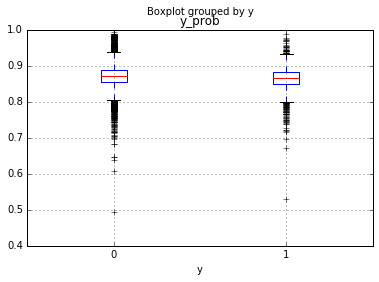

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

pred.boxplot(column='y_prob', by='y')




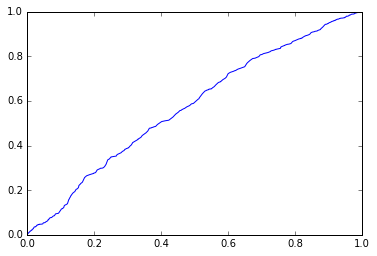

In [131]:
fpr, tpr, thresholds = metrics.roc_curve(y, y_prob[:,1])
plt.plot(fpr, tpr)